In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
np.random.seed(7)

# metrics

In [3]:
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return (f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def score(y_val, pred):
    print(f"fscore        : {fscore(y_val, pred)}")
    print(f"maeOverFscore : {maeOverFscore(y_val, pred)}")

fscore_sklearn = make_scorer(fscore)
maeOverFscore_sklearn = make_scorer(maeOverFscore)

# data load

In [4]:
base = os.getcwd()
data_path = os.path.join(base, 'data')
submit_path = os.path.join(base, 'submit')
model_path = os.path.join(base, 'model')

def load_data(name):
    return np.load(os.path.join(data_path, f"{name}.npy"))

def reshape(data):
    return data.reshape(data.shape[0] * 40 * 40, data.shape[-1])

In [5]:
data = reshape(load_data('dl_train'))

# Feature Selection

## select K
![img](feacture_selection.PNG)

### selectK 7
- [False, False,  True,  True,  True,  True,  True,  True, False, False, False, False, False, True]

### selectK 8
- [False, False,  True,  True,  True,  True,  True,  True, False, False, False, True, False, True]

In [6]:
selectK_7 = [2, 3, 4, 5, 6, 7, 13]
selectK_8 = [2, 3, 4, 5, 6, 7, 11, 13]

# seperate dataset

In [7]:
X = data[:, :-1]
Y = data[:,  -1].reshape(data.shape[0], 1)
data = range(data.shape[0])
print(X.shape, Y.shape)

(121561600, 14) (121561600, 1)


# Kfold

In [8]:
# params = {'learning_rate': 0.01, 'max_depth': -1, 'boosting': 'gbdt', 
#           'objective': 'regression', 'metric': 'mae', 'is_training_metric': True, 
#           'num_leaves': 1024, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 
#           'bagging_freq': 5, 'seed':7}

In [9]:
kfold = KFold(n_splits=4, random_state=7, shuffle=False)
scores = list()

for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
    clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                             n_estimators=400, subsample_for_bin=200000, objective=None, class_weight=None, \
                             min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                             subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
                             n_jobs=- 1, silent=True, importance_type='split')
    
#     train = lgb.Dataset(X[train_idx, :], Y[train_idx, :])
#     val = lgb.Dataset(X[val_idx, :], Y[val_idx, :])

    clf.fit(X[train_idx, :], Y[train_idx, 0], eval_set=[(X[val_idx, :], Y[val_idx, 0])], \
            early_stopping_rounds=100, \
            verbose=True)

#     clf = lgb.train(params, train, valid_sets=val, \
#             early_stopping_rounds=100, \
#             verbose_eval=True)
    
#     clf.save_model(os.path.join(model_path, f'lgb_{i}.txt'), \
#                    num_iteration=clf.best_iteration)
    
    scores.append(score(clf.predict(X[val_idx, :]), Y[val_idx, :]))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[1]	valid_0's l2: 3.62028
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 3.60018
[3]	valid_0's l2: 3.58033
[4]	valid_0's l2: 3.56099
[5]	valid_0's l2: 3.542
[6]	valid_0's l2: 3.5233
[7]	valid_0's l2: 3.5051
[8]	valid_0's l2: 3.48715
[9]	valid_0's l2: 3.46952
[10]	valid_0's l2: 3.45236
[11]	valid_0's l2: 3.43541
[12]	valid_0's l2: 3.4189
[13]	valid_0's l2: 3.40261
[14]	valid_0's l2: 3.38668
[15]	valid_0's l2: 3.37103
[16]	valid_0's l2: 3.35575
[17]	valid_0's l2: 3.34067
[18]	valid_0's l2: 3.32604
[19]	valid_0's l2: 3.31158
[20]	valid_0's l2: 3.29743
[21]	valid_0's l2: 3.28358
[22]	valid_0's l2: 3.26995
[23]	valid_0's l2: 3.25666
[24]	valid_0's l2: 3.24359
[25]	valid_0's l2: 3.23071
[26]	valid_0's l2: 3.21809
[27]	valid_0's l2: 3.2057
[28]	valid_0's l2: 3.19361
[29]	valid_0's l2: 3.18177
[30]	valid_0's l2: 3.17012
[31]	valid_0's l2: 3.15866
[32]	valid_0's l2: 3.14752
[33]	valid_0's l2: 3.13645
[34]	valid_0's l2: 3.12561
[35]	valid_0's l2: 3.1151
[36]	vali

[297]	valid_0's l2: 2.47847
[298]	valid_0's l2: 2.4784
[299]	valid_0's l2: 2.478
[300]	valid_0's l2: 2.47753
[301]	valid_0's l2: 2.47725
[302]	valid_0's l2: 2.47683
[303]	valid_0's l2: 2.47675
[304]	valid_0's l2: 2.47636
[305]	valid_0's l2: 2.47597
[306]	valid_0's l2: 2.47591
[307]	valid_0's l2: 2.47579
[308]	valid_0's l2: 2.4754
[309]	valid_0's l2: 2.47506
[310]	valid_0's l2: 2.47479
[311]	valid_0's l2: 2.47443
[312]	valid_0's l2: 2.474
[313]	valid_0's l2: 2.47394
[314]	valid_0's l2: 2.47359
[315]	valid_0's l2: 2.47332
[316]	valid_0's l2: 2.47324
[317]	valid_0's l2: 2.47285
[318]	valid_0's l2: 2.47261
[319]	valid_0's l2: 2.47223
[320]	valid_0's l2: 2.47187
[321]	valid_0's l2: 2.47181
[322]	valid_0's l2: 2.47149
[323]	valid_0's l2: 2.47142
[324]	valid_0's l2: 2.47106
[325]	valid_0's l2: 2.4708
[326]	valid_0's l2: 2.47074
[327]	valid_0's l2: 2.4704
[328]	valid_0's l2: 2.47012
[329]	valid_0's l2: 2.46978
[330]	valid_0's l2: 2.46951
[331]	valid_0's l2: 2.46947
[332]	valid_0's l2: 2.46916


[188]	valid_0's l2: 2.2001
[189]	valid_0's l2: 2.19914
[190]	valid_0's l2: 2.19822
[191]	valid_0's l2: 2.19735
[192]	valid_0's l2: 2.19645
[193]	valid_0's l2: 2.19555
[194]	valid_0's l2: 2.19469
[195]	valid_0's l2: 2.19386
[196]	valid_0's l2: 2.19302
[197]	valid_0's l2: 2.19223
[198]	valid_0's l2: 2.19136
[199]	valid_0's l2: 2.19058
[200]	valid_0's l2: 2.18973
[201]	valid_0's l2: 2.18888
[202]	valid_0's l2: 2.18815
[203]	valid_0's l2: 2.18734
[204]	valid_0's l2: 2.18653
[205]	valid_0's l2: 2.18576
[206]	valid_0's l2: 2.18491
[207]	valid_0's l2: 2.18421
[208]	valid_0's l2: 2.18342
[209]	valid_0's l2: 2.18256
[210]	valid_0's l2: 2.18174
[211]	valid_0's l2: 2.18095
[212]	valid_0's l2: 2.18024
[213]	valid_0's l2: 2.17947
[214]	valid_0's l2: 2.17872
[215]	valid_0's l2: 2.17798
[216]	valid_0's l2: 2.17734
[217]	valid_0's l2: 2.17667
[218]	valid_0's l2: 2.17606
[219]	valid_0's l2: 2.17541
[220]	valid_0's l2: 2.17467
[221]	valid_0's l2: 2.17407
[222]	valid_0's l2: 2.17347
[223]	valid_0's l2: 2

[78]	valid_0's l2: 2.79963
[79]	valid_0's l2: 2.79426
[80]	valid_0's l2: 2.789
[81]	valid_0's l2: 2.78377
[82]	valid_0's l2: 2.77867
[83]	valid_0's l2: 2.77382
[84]	valid_0's l2: 2.7689
[85]	valid_0's l2: 2.76407
[86]	valid_0's l2: 2.75945
[87]	valid_0's l2: 2.75474
[88]	valid_0's l2: 2.75015
[89]	valid_0's l2: 2.74564
[90]	valid_0's l2: 2.74126
[91]	valid_0's l2: 2.73688
[92]	valid_0's l2: 2.73273
[93]	valid_0's l2: 2.72858
[94]	valid_0's l2: 2.72443
[95]	valid_0's l2: 2.72034
[96]	valid_0's l2: 2.71633
[97]	valid_0's l2: 2.71248
[98]	valid_0's l2: 2.70857
[99]	valid_0's l2: 2.70474
[100]	valid_0's l2: 2.70088
[101]	valid_0's l2: 2.69722
[102]	valid_0's l2: 2.69357
[103]	valid_0's l2: 2.69012
[104]	valid_0's l2: 2.68661
[105]	valid_0's l2: 2.68316
[106]	valid_0's l2: 2.67979
[107]	valid_0's l2: 2.6765
[108]	valid_0's l2: 2.67323
[109]	valid_0's l2: 2.67009
[110]	valid_0's l2: 2.66695
[111]	valid_0's l2: 2.66381
[112]	valid_0's l2: 2.66082
[113]	valid_0's l2: 2.65779
[114]	valid_0's l2

[373]	valid_0's l2: 2.4372
[374]	valid_0's l2: 2.43702
[375]	valid_0's l2: 2.43686
[376]	valid_0's l2: 2.43665
[377]	valid_0's l2: 2.43642
[378]	valid_0's l2: 2.43627
[379]	valid_0's l2: 2.43609
[380]	valid_0's l2: 2.43591
[381]	valid_0's l2: 2.4357
[382]	valid_0's l2: 2.43551
[383]	valid_0's l2: 2.43535
[384]	valid_0's l2: 2.43511
[385]	valid_0's l2: 2.43492
[386]	valid_0's l2: 2.43475
[387]	valid_0's l2: 2.43451
[388]	valid_0's l2: 2.43433
[389]	valid_0's l2: 2.43423
[390]	valid_0's l2: 2.43411
[391]	valid_0's l2: 2.43389
[392]	valid_0's l2: 2.43373
[393]	valid_0's l2: 2.43356
[394]	valid_0's l2: 2.43334
[395]	valid_0's l2: 2.43318
[396]	valid_0's l2: 2.43303
[397]	valid_0's l2: 2.43288
[398]	valid_0's l2: 2.43272
[399]	valid_0's l2: 2.43257
[400]	valid_0's l2: 2.43247
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 2.43247
fscore        : 0.5894452330389313
maeOverFscore : 1.7323487886539732
[1]	valid_0's l2: 4.32619
Training until validation scores don't improve

[263]	valid_0's l2: 2.88803
[264]	valid_0's l2: 2.88742
[265]	valid_0's l2: 2.88706
[266]	valid_0's l2: 2.88649
[267]	valid_0's l2: 2.88591
[268]	valid_0's l2: 2.88556
[269]	valid_0's l2: 2.885
[270]	valid_0's l2: 2.8846
[271]	valid_0's l2: 2.88404
[272]	valid_0's l2: 2.88365
[273]	valid_0's l2: 2.88312
[274]	valid_0's l2: 2.88281
[275]	valid_0's l2: 2.88234
[276]	valid_0's l2: 2.88205
[277]	valid_0's l2: 2.88151
[278]	valid_0's l2: 2.88104
[279]	valid_0's l2: 2.88074
[280]	valid_0's l2: 2.88023
[281]	valid_0's l2: 2.87977
[282]	valid_0's l2: 2.87933
[283]	valid_0's l2: 2.8791
[284]	valid_0's l2: 2.87862
[285]	valid_0's l2: 2.8784
[286]	valid_0's l2: 2.87796
[287]	valid_0's l2: 2.8775
[288]	valid_0's l2: 2.87734
[289]	valid_0's l2: 2.87696
[290]	valid_0's l2: 2.8765
[291]	valid_0's l2: 2.87606
[292]	valid_0's l2: 2.87592
[293]	valid_0's l2: 2.87546
[294]	valid_0's l2: 2.87528
[295]	valid_0's l2: 2.87485
[296]	valid_0's l2: 2.87473
[297]	valid_0's l2: 2.87434
[298]	valid_0's l2: 2.87392

In [10]:
for f_value, mae_value in scores:
    print(f"fscore : {f_value} \t maeOverFscore : {mae_value}")

TypeError: cannot unpack non-iterable NoneType object

# 시각화

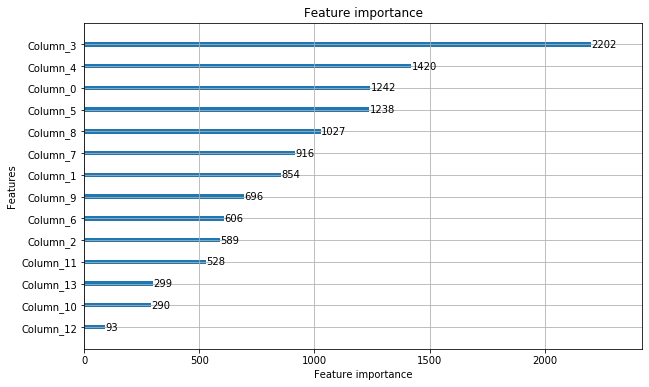

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

# 제출

In [17]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index=False)

In [18]:
submit(clf, 'lightbgm_all_features_train_val')

In [23]:
x_train = X[:112000000, :]
y_train = Y[:112000000, 0]

x_val = X[112000000:, :]
y_val = Y[112000000:, 0]

In [24]:
x_val.shape, y_val.shape

((9561600, 14), (9561600,))

In [ ]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                         n_estimators=400, subsample_for_bin=200000, objective=None, class_weight=None, \
                         min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                         subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
                         n_jobs=- 1, silent=True, importance_type='split')

clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], \
        early_stopping_rounds=100, \
        verbose=True)

In [ ]:
submit(clf, 'lightbgm_all_features_all_data')

# Lightbgm

# Lightbgm train

In [ ]:
params = {'learning_rate': 0.01, 'max_depth': -1, 'boosting': 'gbdt', 
          'objective': 'regression', 'metric': 'mae', 'is_training_metric': True, 
          'num_leaves': 1024, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 
          'bagging_freq': 5, 'seed':7}

model = lgb.train(params, train, 1000, val, verbose_eval=10, \
                  early_stopping_rounds=100)

In [ ]:
pred = model.predict(x_val)

score(y_val, pred)

# Lightbgm LGBMRegressor

In [ ]:
# lightgbm.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, \
#                              n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, \
#                              min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
#                              subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
#                              n_jobs=- 1, silent=True, importance_type='split')

In [ ]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                             n_estimators=400, subsample_for_bin=200000, objective=None, class_weight=None, \
                             min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                             subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
                             n_jobs=- 1, silent=True, importance_type='split')

In [ ]:
# fit(X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, \
#     eval_sample_weight=None, eval_init_score=None, eval_metric=None, \
#     early_stopping_rounds=None, verbose=True, feature_name='auto', \
#     categorical_feature='auto', callbacks=None, init_model=None)

In [ ]:
clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], \
        eval_metric=maeOverFscore_sklearn, early_stopping_rounds=100, \
        verbose=True, eval_names='maeOverFscore')

# Feature Selection

# KFold

In [ ]:
kfold = KFold(n_splits=4, random_state=7, shuffle=True)

for (train_idx, val_idx) in kfold.split(Y):
    ridge = Ridge(alpha=10.0).fit(X[train_idx, :], Y[train_idx])
    
    score(Y[val_idx], ridge.predict(X[val_idx, :]))

# 시각화

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax)

In [ ]:
# lgb_param = {
#     'objective': 'regression',
#     'metrics': maeOverFscore_sklearn,
#     'learning_rate' : 0.01,
#     'eval_metric': maeOverFscore_sklearn,
#     'early_stopping_rounds' : 100,
#     'eval_set': val_data,
#     'verbose': True,
#     'stratified':False,
#     'verbose_eval': 10,
#     'nfold': 5,
#     'num_boost_round': 99999,
# }

# cv_result = lgb.cv(
#     lgb_param,
#     train_data
# )

# lgb_model = lgb.train(
#   lgb_param,
#   train_data,
#   num_boost_round=len(cv_result['l1-mean'])
# )

# Submit

In [ ]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    if preprocess is not None:
        x_test = preprocess.transform(x_test)
        print("transform")
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index = False)

In [ ]:
submit(lgb_model, 'lightbgm_selectK')

- https://dacon.io/competitions/official/235591/mysubmission/
- D:\인공지능_공모전\github\submit